In [1]:
import os, sys
import esutil
import healpy as hp
import numpy as np
import fitsio
sys.path.append('../')
from xd import *
from run_DMASS_Y3 import *
from utils import *
import healpy as hp
from systematics import *
from cmass_modules import io
os.chdir('../../DMASS_XDGMM/code_py3/')
print(os.getcwd())
from xdgmm import XDGMM as XDGMM_Holoien
os.chdir('../../DMASSY3/code_py3/')
print(os.getcwd())

gold_spt = fitsio.read('../output/test/train_cat/y3/gold_spt.fits')

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


/users/PCON0003/warner785/DMASS_XDGMM/code_py3
/users/PCON0003/warner785/DMASSY3/code_py3


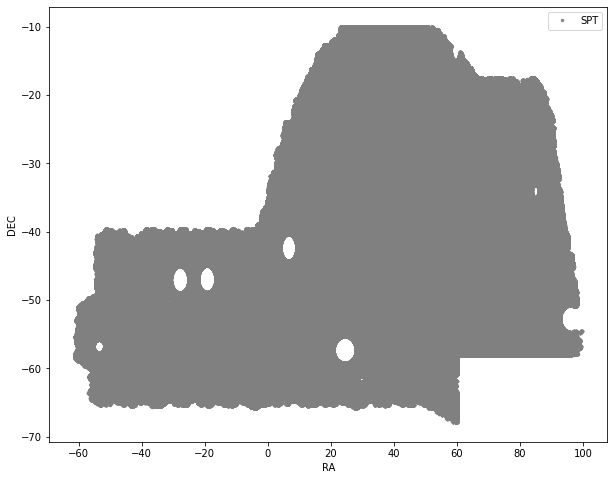

In [2]:
#check spt fits file:
spatialcheck([gold_spt], 
             label = ['SPT'], convert = None, ratag='RA',dectag='DEC')

In [3]:
#split into 4 regions:

mask1 = gold_spt['DEC']>-25 | gold_spt['DEC']==-25
mask2 = gold_spt['DEC']>-38 & gold_spt['DEC']<-25 | gold_spt['DEC']==-38
mask3 = gold_spt['DEC']>-50 & gold_spt['DEC']<-38 | gold_spt['DEC']==-50
mask4 = gold_spt['DEC']<-50

spt1 = gold_spt[mask1]
spt2 = gold_spt[mask2]
spt3 = gold_spt[mask3]
spt4 = gold_spt[mask4]

TypeError: ufunc 'bitwise_or' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [4]:
# Su's method:

def GenerateRegions(jarrs, jras, jdecs, jfile, njack, jtype):

    import kmeans_radec
    
    if jtype=='generate':
        rdi = np.zeros( (len(jarrs),2) )
        rdi[:,0] = jras# jarrs[gindex][jras[gindex]]
        rdi[:,1] = jdecs #jarrs[gindex][jdecs[gindex]]

        if jfile == None:
            jfile = 'JK-{0}.txt'.format(njack)
        km = kmeans_radec.kmeans_sample(rdi, njack, maxiter=200, tol=1.0e-5)

        if not km.converged:
            raise RuntimeError("k means did not converge")
        np.savetxt(jfile, km.centers)

    elif jtype=='read':
        print('read stored jfile :', jfile)
        centers = np.loadtxt(jfile)
        km = kmeans_radec.KMeans(centers)
        njack = len(centers)

    return [km, jfile]


def AssignIndex(jarrs, jras, jdecs, km):
    
    ind = []
    for i in range(len(jarrs)):
        rdi = np.zeros( (len(jarrs[i]),2) )
        rdi[:,0] = jras[i]
        rdi[:,1] = jdecs[i]
        index = km.find_nearest(rdi)
        ind.append(index[0])
    return np.array(ind)


def construct_jk_catalog( cat, njack = 50, root='./', jtype = 'generate', jfile = 'jkregion.txt', suffix = '' , retind = False):

    import os
    os.system('mkdir '+root)
    km, jfile = GenerateRegions(cat, cat['RA'], cat['DEC'], root+jfile, njack, jtype)
    ind = AssignIndex(cat, cat['RA'], cat['DEC'], km)
    #ind_rand = AssignIndex(rand, rand['RA'], rand['DEC'], km)
    

    if retind : 
        if 'JKindex' in cat.dtype.names : cat['JKindex'] = ind
        else : cat = appendColumn(cat, name = 'JKindex', value = ind, dtypes=None)
        return cat

    else : 
        catlist = []
        for i in range(njack):
            mask = (ind == i)
            catlist.append(cat[mask])
            #mask_rand = (ind_rand == i)
            #_constructing_input_file(cat[mask], rand[mask_rand], root = root, suffix = suffix)
            
        #os.remove(jkfile)  

        return catlist

In [ ]:
construct_jk_catalog(gold_spt)

X (11385, 2)  centers (50, 2)  tol=1e-05  maxiter=200
53 iterations  cluster sizes: [265 291 306 338 319 252 321 228 127 271 287 187 304 197 178 266 129 141
 274 231 247 294 308 172 306 231 157 136 193 309 224 157 256 182 203 136
 203 173 184 295 283 365 214 112 222 118 139 249 258 147]
X (32409121, 2)  centers (50, 2)  tol=1e-05  maxiter=200
